# Chapter 4
# Finite-Dimensional Optimization

In this chapter we examine methods for optimizing a function with respect to a finite
number of variables. In the finite-dimensional optimization problem, one is given a
real-valued function $f$ defined on $X \subset R^n$ and asked to find an $x^* \in X$ such that
$f(x^*) \geq f(x)$ for all $x \in X$. We denote this problem

$$\max_{x \in X} f(x)$$

and call $f$ the objective function, $X$ the feasible set, and $x^*$, if it exists, a maximum.

There is a close relationship between the finite-dimensional optimization problems
discussed in this chapter and the rootfinding and complementarity problems
discussed in the previous chapter. The first-order necessary conditions of an unconstrained
problem pose a rootfinding problem; the Karush-Kuhn-Tucker first-order
necessary conditions of a constrained optimization problem pose a complementarity
problem. The rootfinding and complementarity problems associated with optimization
problems are special in that they possess a natural merit function, the objective
function itself, which may be used to determine whether iterations are converging on
a solution.

Over the years, numerical analysts have studied finite-dimensional optimization
problems extensively and have devised a variety of algorithms for solving them quickly
and accurately. We begin our discussion with derivative-free methods, which are useful
if the objective function is rough or if its derivatives are expensive to compute.
We then turn to Newton-type methods for unconstrained optimization, which employ
derivatives or derivative estimates to locate an optimum. Univariate unconstrained
optimization methods are of particular interest because many multivariate optimization
algorithms use the strategy of first determining a linear direction to move in,
and then finding the optimal point in that direction. We conclude with a discussion
of how to solve constrained optimization problems.

## 4.1 Derivative-Free Methods

As was the case with univariate rootfinding, optimization algorithms exist that will
place progressively smaller brackets around a local maximum of a univariate function.
Such methods are relatively slow, but do not require the evaluation of function
derivatives and are guaranteed to find a local optimum to a prescribed tolerance in a
known number of steps.

The most widely-used derivative-free method is the **golden search** method.

Suppose
we wish to find a local maximum of a continuous univariate function $f(x)$ on
the interval $[a; b]$. Pick any two numbers in the interior of the interval, say $x_1$ and $x_2$
with $x_1 < x_2$. Evaluate the function and replace the original interval with $[a; x2]$ if
$f(x_1) > f(x_2)$ or with $[x_1; b]$ if $f(x_2) \geq f(x_1)$.

A key issue is how to pick the interior evaluation points. Two simple criteria lead
to the most widely-used strategy. First, the length of the new interval should be
independent of whether the upper or lower bound is replaced. Second, on successive
iterations, one should be able to reuse an interior point from the previous iteration so
that only one new function evaluation is performed per iteration. These conditions
are uniquely satisfied by selecting $x_i = a + \alpha_i (b - a)$, where

$$\alpha_1 = \frac{3-\sqrt 5}{2}$$

$$\alpha_2 = \frac{\sqrt 5 -1}{2}$$

The value $\alpha_2$ is known as the golden ratio, a number dear to the hearts of Greek
philosophers and Renaissance artists.

In [3]:
import numpy as np
from numpy import append, array, diagonal, tril, triu
from numpy.linalg import inv
from scipy.linalg import lu
#from scipy.linalg import solve
from pprint import pprint
from numpy import array, zeros, diag, diagflat, dot

from sympy import *
import sympy as sym
init_printing()

In [13]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [5]:
maxit = 1000
tol = 1/10000
x0= np.array([0,3])
f = lambda x: x * np.cos(x ** 2)

a,b = 0,3

<IPython.core.display.Javascript object>


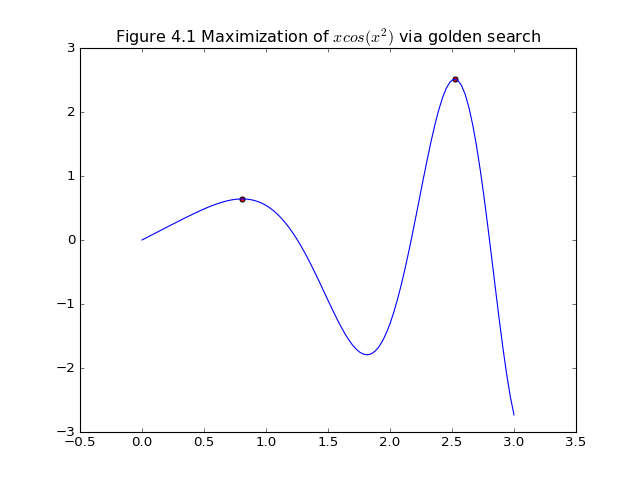

In [14]:
x = np.linspace(0,3, 100)
y = f(x)
plt.plot(x,y)
plt.scatter( np.array([0.8083,2.5234]), f(np.array([0.8083,2.5234])) , c='r' )
plt.title("Figure 4.1 Maximization of $x cos(x^2)$ via golden search")

In [7]:
alpha1 = (3 - np.sqrt(5)) / 2
alpha2 = (np.sqrt(5) - 1) / 2
if a > b:
    a, b = b, a

x1 = a + alpha1 * (b - a)
x2 = a + alpha2 * (b - a)

f1, f2 = f(x1), f(x2)

d = (alpha1 * alpha2)*(b - a)

In [8]:
while d > tol:
    d = d * alpha2
    if f2 < f1: # x2 is new upper bound
        x2, x1 = x1, x1 - d
        f2, f1 = f1, f(x1)
    else:  # x1 is new lower bound
        x1, x2 = x2, x2 + d
        f1, f2 = f2, f(x2)

In [9]:
#x1 if f1 > f2 else x2

In [10]:
if f1>f2:
    x = x2
else:
    x = x1      
x    

In [11]:
def mygolden(f,a, b, maxit = 1000, tol = 1/10000):
    alpha1 = (3 - np.sqrt(5)) / 2
    alpha2 = (np.sqrt(5) - 1) / 2
    if a > b:
        a, b = b, a
        
    x1 = a + alpha1 * (b - a)
    x2 = a + alpha2 * (b - a)

    f1, f2 = f(x1), f(x2)

    d = (alpha1 * alpha2)*(b - a)
    while d > tol:
        d = d * alpha2
        if f2 < f1: # x2 is new upper bound
            x2, x1 = x1, x1 - d
            f2, f1 = f1, f(x1)
        else:  # x1 is new lower bound
            x1, x2 = x2, x2 + d
            f1, f2 = f2, f(x2)
            
    if f1>f2:
        x = x2
    else:
        x = x1      
    return x    

In [12]:
mygolden(f, 0, 3)

Execution of this script yields the result $x = 0.8083$. As can be seen in Figure 4.1,
this point is a local maximum, but not a global maximum in $[0; 3]$. The golden search
method is guaranteed to find the global maximum when the function is concave.
However, as the present example makes clear, this need not be true when the optimand
is not concave.

## 4.2 Newton-Raphson Method

The Newton-Raphson method for maximizing an objective function uses successive
quadratic approximations to the objective in the hope that the maxima of the approximants
will converge to the maximum of the objective. The Newton-Raphson
method is intimately related to the Newton method for solving rootfinding problems.

## 4.3 Quasi-Newton Methods


Quasi-Newton methods employ a similar strategy to the Newton-Raphson method,
but replace the Hessian of the objective function (or its inverse) with a negative
definite approximation, guaranteeing that function value can be increased in the direction
of the Newton step. The most eÆcient quasi-Newton algorithms employ an
approximation to the inverse Hessian, rather than the Hessian itself, in order to avoid
performing a linear solve, and employ updating rules that do not require second
derivative information to ease the burden of implementation and the cost of computation.

In [22]:
f = lambda x,y:(-100*(y-x**2)**2-(1-x)**2)

# def f(x,y):
#     # the height function
#     return (1 - x / 2 + x**5 + y**3) * np.exp(-x**2 -y**2)

n = 256
x = np.linspace(-0.25, 1.25, n)
y = np.linspace(-0.25, 1.25, n)
X,Y = np.meshgrid(x, y) 

<IPython.core.display.Javascript object>


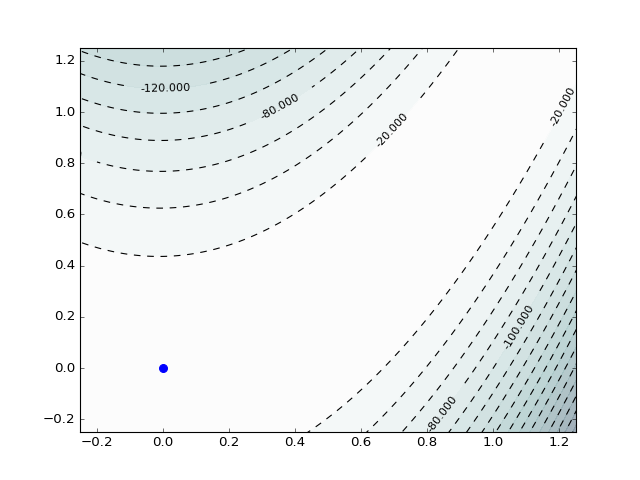

In [30]:
plt.figure()
x0,y0 = 0,0
# use plt.contourf to filling contours
# X, Y and value for (X,Y) point
plt.contourf(X, Y, f(X, Y), 38, alpha=.75,cmap='bone')# cmap=plt.cm.hot)

# use plt.contour to add contour lines
C = plt.contour(X, Y, f(X, Y), 38, colors='black', linewidth=.5)

plt.clabel(C, inline=True, fontsize=10)
# plt.xticks(())
# plt.yticks(())

# set dot styles
plt.scatter([x0, ], [y0, ], s=50, color='b')



plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)